# Imports

In [1]:
import pandas as pd # dataframes
from sklearn.discriminant_analysis import StandardScaler # scale and center numerical features
from sklearn.ensemble import IsolationForest # anomaly detection
from sklearn.decomposition import PCA # primary component analysis
import matplotlib.pyplot as plt # plots
from sklearn import set_config # return pd.DataFrame from transformers
import pickle # move transformers and estimators between notebooks

# custom helper functions
from helper_functions import feature_distribution_plot, pca_plot, scree_plot

# Background
## Principal Component Analysis
Principal component analysis (PCA) is technique used to decrease dimensionality of data in statistics and machine-learning. In the process, it tries to maintain the original variability as best as possible.

A PCA:
1. Requires **normally-distributed numerical** data.
2. Utilizes feature correlations and is therefore **sensitive to outliers and feature scales**. Features should therefore be standardized to zero mean and unit variance.

# Settings

In [2]:
# set sklearn functions to output pd.DataFrames
set_config(transform_output='pandas')

# plot figures with higher resolutions
plt.rcParams['figure.dpi'] = 150

# Preprocess the Data

## Reading The Data

In [3]:
df = pd.read_csv('./data/hcvdat11_Anomaly.csv')

## Missing Data
Are there missing values in the dataset?

In [4]:
df.isna().values.any()

False

## Inspecting The Dataframe

In [5]:
df.head(4)

,Unnamed: 0,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7


## Dropping Columns
Drop the malformatted index-column at the beginning.

In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)

Principal Component Analysis (PCA) does not work well with categorical variables.

One-Hot-Encoding could enable PCA for e.g. binary variables but could also introduce errors. 
Addionaly the PCA only works with numerical values.

Therefore, drop the column 'Sex':

In [7]:
df.drop(columns=['Sex'], inplace=True)
df.head(4)

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,32,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,32,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,32,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,32,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7


## Analyze Feature Distributions

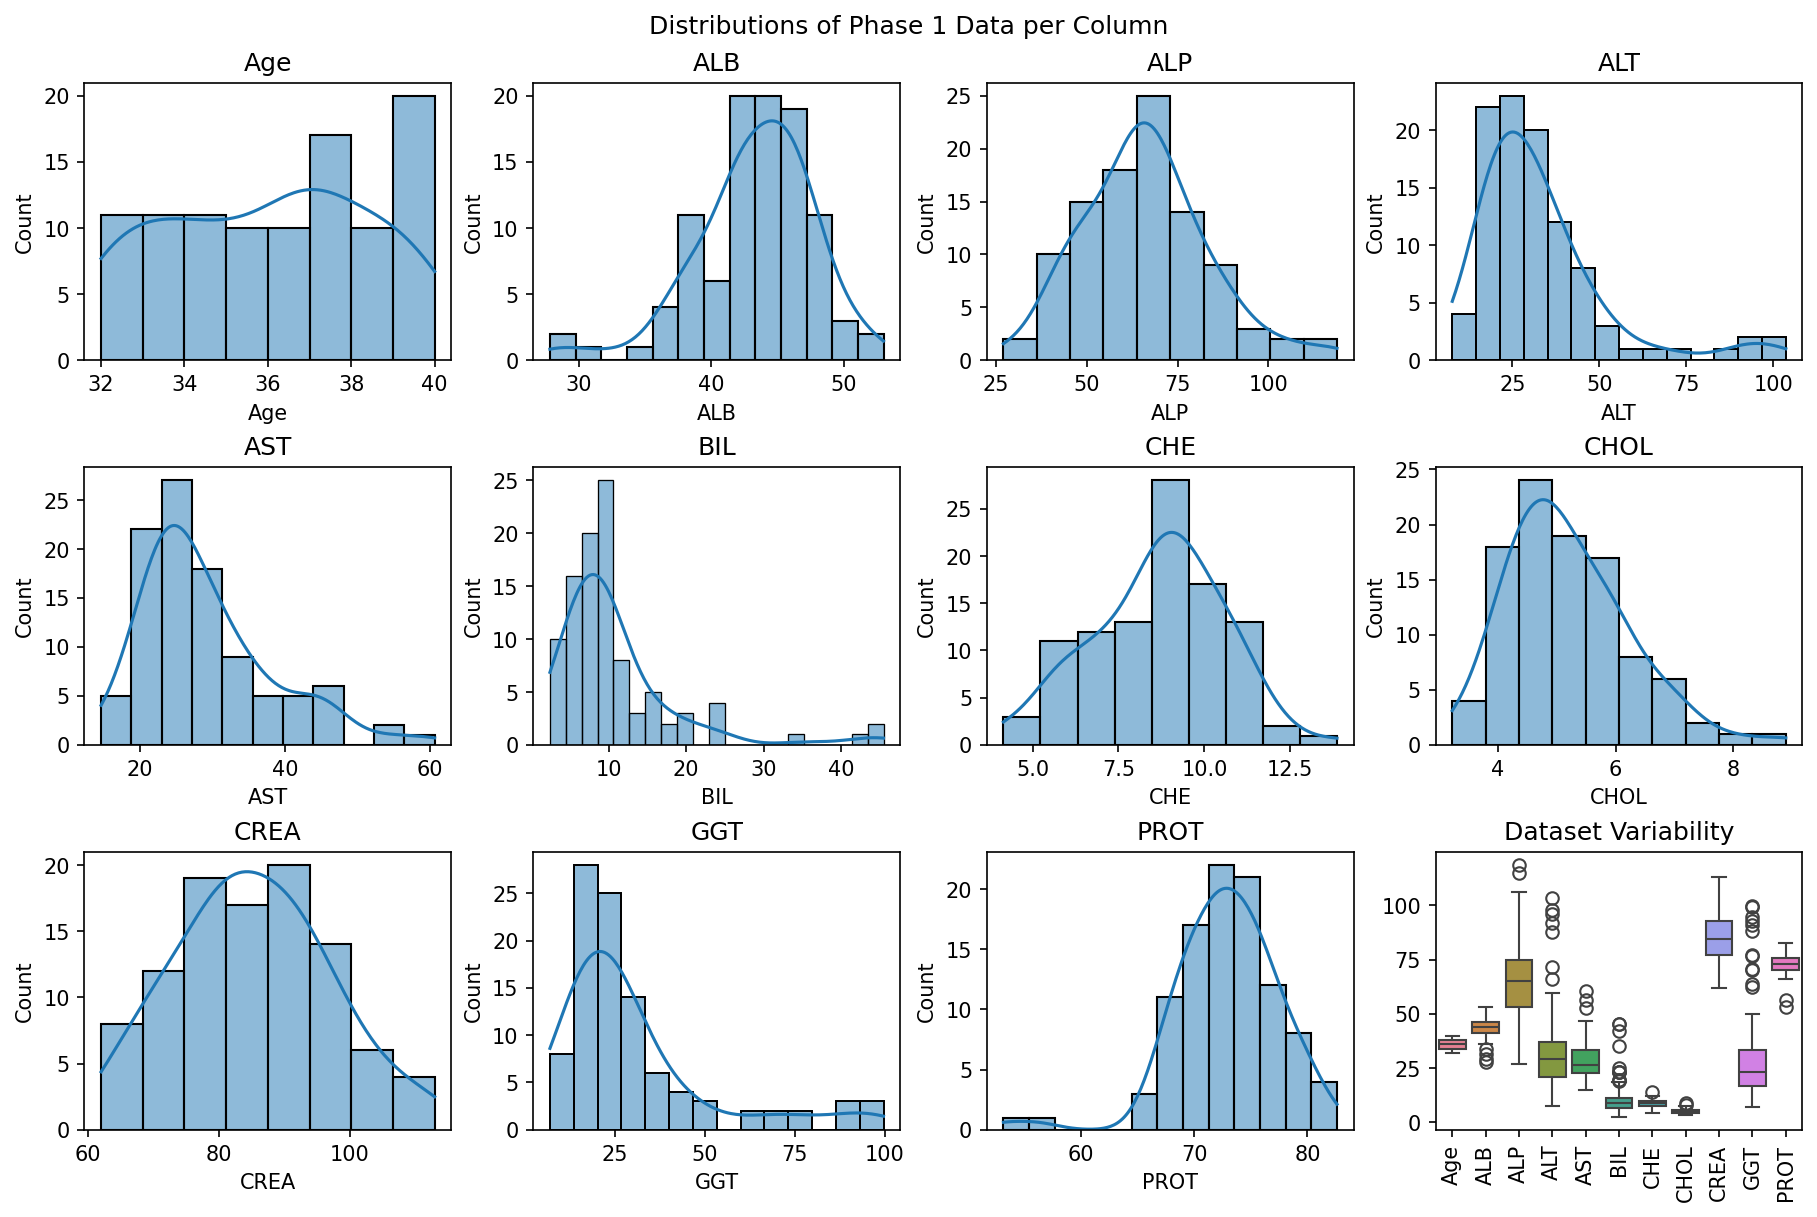

In [8]:
plot_distributions_original = feature_distribution_plot(df=df, suptitle='Distributions of Phase 1 Data per Column')

### Discussion
Most features (ALB, ALT, AST, BIL, CHOL, GGT and PROT) roughly follow normal distributions with outliers. KREA, CHE and ALP are normally distributed without outliers. Age alone is not normally distributed. Therefore, after standardization to control for outliers, the data is suitable for pca.

## Standardize Features
Standardize the features to scale and center numerical features using a standard scaling approach to have basic scaling but leave the outliers as they are for the anomaly detection to figure out:

In [9]:
scaler = StandardScaler() # instantiate scaler
df_scaled = scaler.fit_transform(df) # fit the scaler create scaled data

Inspect the scaled features:

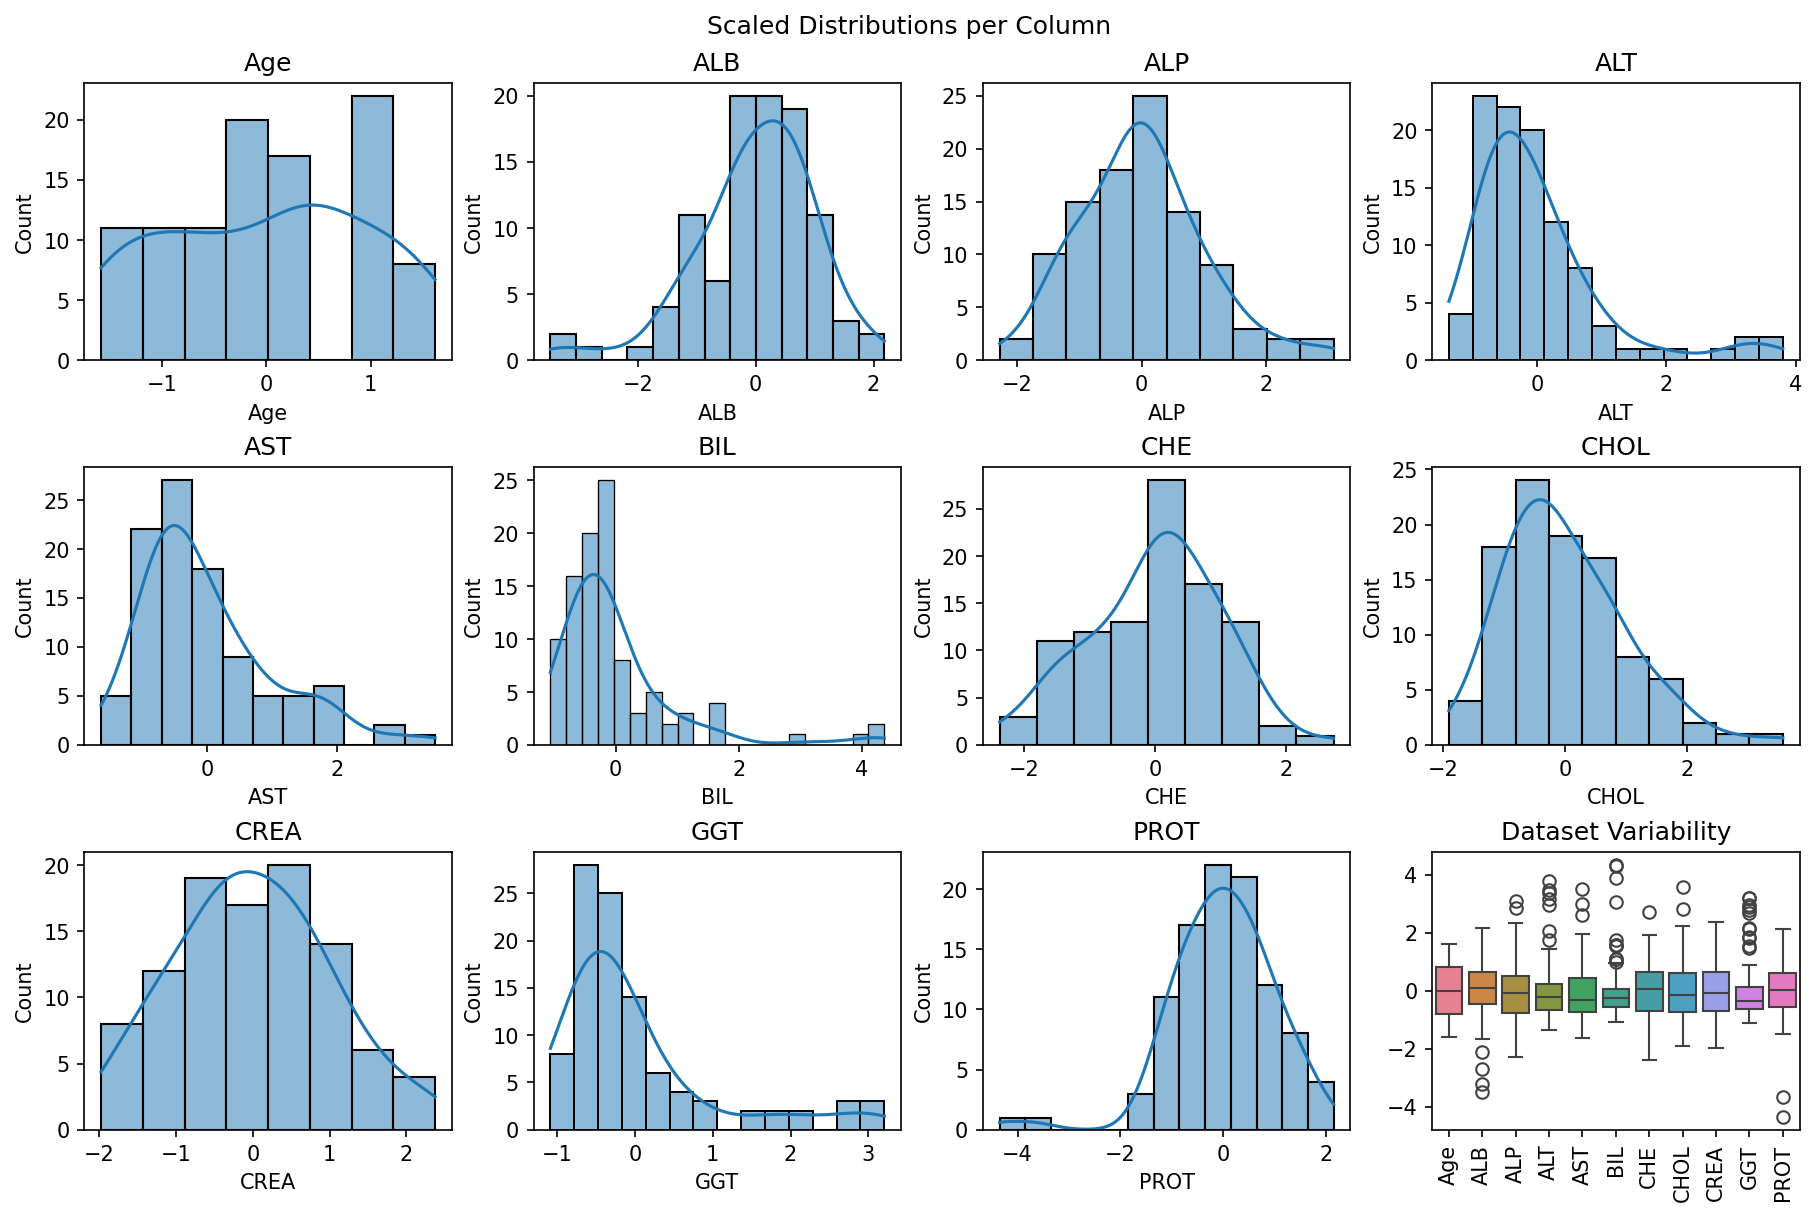

In [10]:
plot_distributions_scaled = feature_distribution_plot(df=df_scaled, suptitle='Scaled Distributions per Column')

### Discussion
All features have a mean of zero and similar scales.

# Perform A PCA
Q: Would it make sense to use a reduced number of Principal Components instead of the original features?

A: Yes, the very purpose of principal component analysis is to reduce the number of dimensions in data. This is usually desired to make data more computationally effective and easier to interpret for humans.

In [11]:
# set the number of principal components here
N_COMPONENTS = 11

pca = PCA(n_components=N_COMPONENTS)

In [12]:
# create principal components using the scaled data
df_pca = pca.fit_transform(X=df_scaled)

In [13]:
# export the pca
with open('./pickle/pca_phase_one.pkl', '+wb') as file:
    pickle.dump(pca, file)

Principal components are sorted by the degree to which they explain the target's variance (highest to lowest).

Therefore plot the first two primary components:

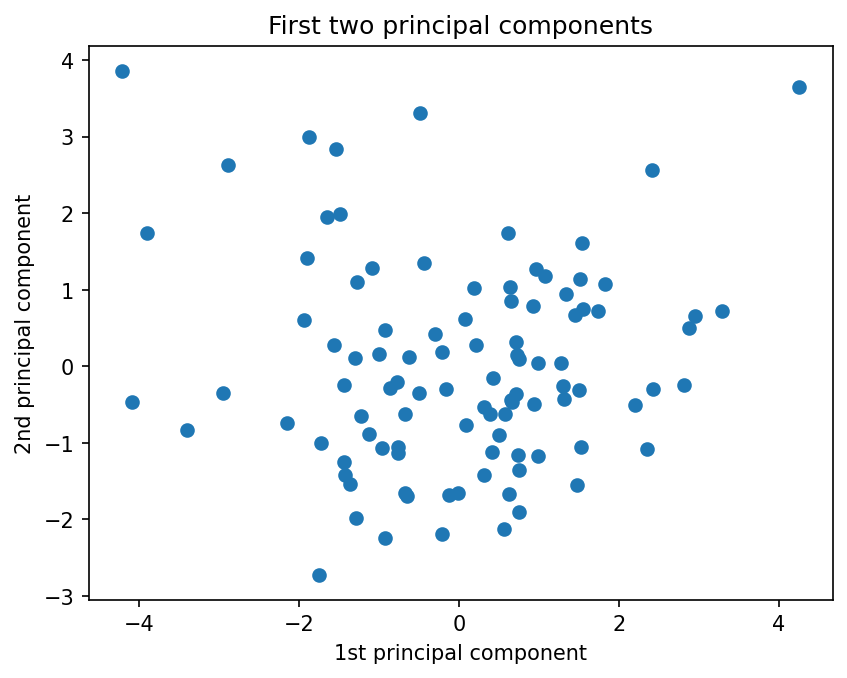

In [14]:
fig, ax = plt.subplots()

plot_pca_comparison = pca_plot(ax=ax, first_pc=df_pca['pca0'], second_pc=df_pca['pca1'], title='First two principal components')

plt.show()

## Scree Plot
We can analyze the influence of single principal components on the explained variance ratio using so-called scree plots. 

- Single explained variance ratios of the principal components are already included as attributes in a fitted pca:

In [15]:
# display the explained variance ratio of the principal components
pd.DataFrame(pca.explained_variance_ratio_).transpose()

,0,1,2,3,4,5,6,7,8,9,10
0,0.230914,0.164188,0.115695,0.093766,0.085509,0.079486,0.068685,0.061289,0.045982,0.033719,0.020767


- Cumulative variance ratios need to be calculated

Now plot the single and cumulative explained ratios

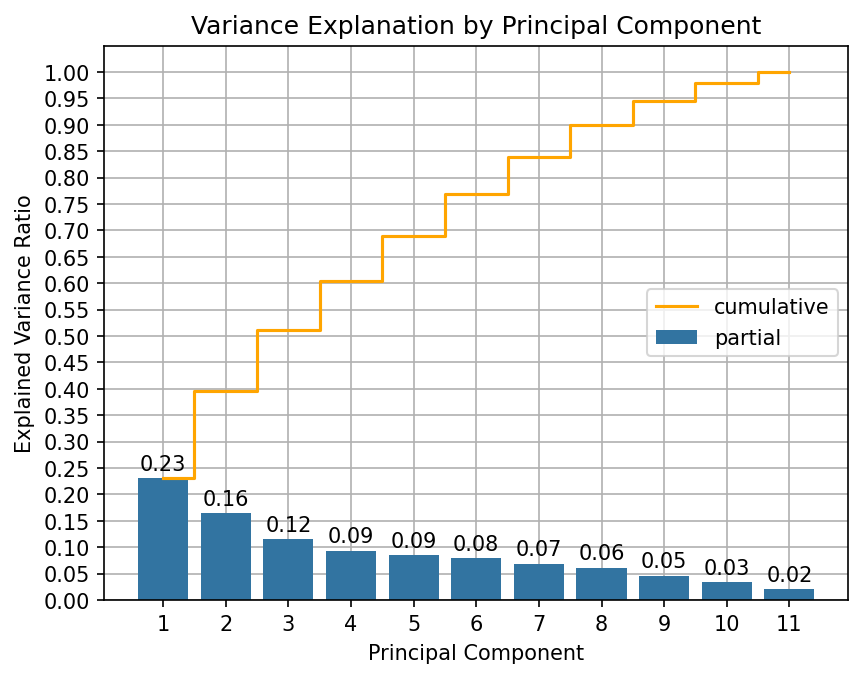

In [16]:
fig, ax = plt.subplots()

plot_scree = scree_plot(ax=ax, pca=pca, title='Variance Explanation by Principal Component')

plt.show()

### Discussion
The scree plot shows us how much variance ratio each principal component explains, and how many principal components we need to explain the variance to a certain degree. 

Here, singular principal components do not contribute strongly to the explanation. To explain at least 95 %, at least 9 principal components are necessary.

In [17]:
# TODO: Include Loading Plot

# Build an Anomaly Detection Model
From the [scikit-learn documentation](https://scikit-learn.org/stable/modules/outlier_detection.html) we learn, that the two algorithms isolation forest and local outlier factor score the best for outlier detection.

Use the Isolation Forest here because it provides decision boundaries.

In [18]:
first_two_pcs = df_pca.iloc[:,:2]

In [19]:
# TODO: Tweak parameters so that not all instances are categorized the same way
isolation_forest = IsolationForest(max_samples=10, contamination=0.1, bootstrap=True, random_state=42)
isolation_forest.fit(first_two_pcs)

IsolationForest(bootstrap=True, contamination=0.1, max_samples=10,
                random_state=42)

In [20]:
# export the isolation forest
#uncomment to create new pickle

#with open('./pickle/isolation_forest_phase_one.pkl', '+wb') as file:
    #pickle.dump(isolation_forest, file)